In [ ]:
from datasets import load_dataset, DownloadConfig
download_config = DownloadConfig(cache_dir="../sentiment")

ds = load_dataset("tridm/UIT-VSMEC", download_config=download_config)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.json: 0.00B [00:00, ?B/s]

valid.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/5548 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/693 [00:00<?, ? examples/s]

In [ ]:
ds['train'].unique("Emotion")

['Other', 'Disgust', 'Enjoyment', 'Anger', 'Surprise', 'Sadness', 'Fear']

In [ ]:
count = 0
for i in ds['train']['Emotion']:
   if i == 'Enjoyment':
     count += 1
print(count)

1558


In [ ]:
MAP5 = {
    "Enjoyment": "joy",
    "Sadness":   "sadness",
    "Anger":     "anger",
    "Disgust":   "anger",   # gộp vào anger
    "Fear":      "fear",
    "Surprise":  "surprise",
    "Other":     None       # bỏ hoặc map thành 'neutral' nếu bạn cần preset có neutral
}

CLASSES = ["joy","sadness","anger","fear","surprise"]
label2id = {c:i for i,c in enumerate(CLASSES)}

def to_5_labels(ex):
    emo = ex["Emotion"]
    mapped = MAP5.get(emo, None)
    ex["labels"] = -1 if mapped is None else label2id[mapped]
    return ex

ds5 = ds.map(to_5_labels)
ds5 = ds5.filter(lambda ex: ex["labels"] != -1)  # loại 'Other' nếu đặt None


Map:   0%|          | 0/5548 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5548 [00:00<?, ? examples/s]

Filter:   0%|          | 0/686 [00:00<?, ? examples/s]

Filter:   0%|          | 0/693 [00:00<?, ? examples/s]

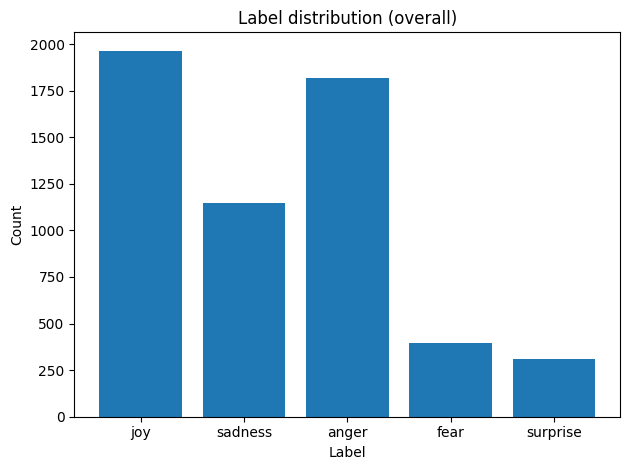

Counts (overall): {'joy': 1965, 'sadness': 1149, 'anger': 1818, 'fear': 395, 'surprise': 309}


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

all_labels = []
for split in ds5.keys():
    all_labels.extend(ds5[split]["labels"])

cnt_all = Counter(all_labels)
x_names = CLASSES
y_counts = [cnt_all.get(i, 0) for i in range(len(CLASSES))]

plt.figure()
plt.bar(x_names, y_counts)
plt.title("Label distribution (overall)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Counts (overall):", {CLASSES[i]: y_counts[i] for i in range(len(CLASSES))})


In [ ]:
import re
import string
from bs4 import BeautifulSoup

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    return text

def clean_batch(batch):
    return {"Sentence": [clean_text(x) for x in batch["Sentence"]]}

ds5 = ds5.map(clean_batch, batched=True)
ds5['train']['Sentence']

Map:   0%|          | 0/4527 [00:00<?, ? examples/s]

Map:   0%|          | 0/545 [00:00<?, ? examples/s]

Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Column(['cho đáng đời con quỷ  về nhà lôi con nhà mày ra mà đánh  ', 'lo học đi  yêu đương lol gì hay lại thích học sinh học', 'uớc gì sau này về già vẫn có thể như cụ này ', 'mỗi lần có video của con là cứ coi đi coi lại hoài  cưng con quá ', 'thằng kia sao mày bắt vợ với bồ tao dọn thế kia  nhà mày ở đâu tao đến thịt mày chết'])

In [ ]:
pip install py_vncorenlp

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.8 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4304 sha256=e75bcd0258647f4d82d13399e667561cd3ee1087d33f01619126cc56001727c9
  Stored in directory: /root/.cache/pip/wheels/db/e5/ff/f4a1b4ece36e8582db1ca71150a34e987e65df50c35974e9bb
Successfully built py_vncorenlp


In [ ]:
import os, py_vncorenlp

SAVE_DIR = "../sentiment/vncorenlp"
os.makedirs(SAVE_DIR, exist_ok=True)

# Tải model nếu chưa có (chạy 1 lần)
if not os.path.exists(os.path.join(SAVE_DIR, "VnCoreNLP-1.1.1.jar")):
    py_vncorenlp.download_model(save_dir=SAVE_DIR)

# Chỉ tạo segmenter nếu chưa có trong session
if "rdrsegmenter" not in globals():
    rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=SAVE_DIR)

# nếu trước đó có set_format('torch'), nên reset để tránh xung đột kiểu
for sp in ["train", "validation"]:
    try:
        ds5[sp].reset_format()
    except Exception:
        pass

def seg_inplace(batch):
    return {"Sentence": [rdrsegmenter.word_segment(x) for x in batch["Sentence"]]}

for sp in ["train", "validation"]:
    ds5[sp] = ds5[sp].map(seg_inplace, batched=True, batch_size=64)

# kiểm tra
print(ds5["train"]["Sentence"][:3])


VnCoreNLP model folder /content/drive/MyDrive/sentiment/vncorenlp already exists! Please load VnCoreNLP from this folder!


Parameter 'function'=<function seg_inplace at 0x7c970f8bac00> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/4527 [00:00<?, ? examples/s]

Map:   0%|          | 0/545 [00:00<?, ? examples/s]

[['cho đáng_đời con quỷ về nhà lôi con nhà mày ra mà đánh'], ['lo học đi yêu_đương lol gì hay lại thích học_sinh học'], ['uớc gì sau_này về già vẫn có_thể như cụ này']]


In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

# 1) Chuẩn hoá mỗi phần tử thành CHUỖI
def to_text(x):
    if isinstance(x, list):
        if len(x) and isinstance(x[0], list):   # list-of-list
            return " ".join(" ".join(s) for s in x)
        return " ".join(map(str, x))            # list token/chuỗi
    return str(x)

# 2) Tokenize theo batch, đặt max_length RÕ RÀNG
MAX_LEN = 128
def tok_fn(batch):
    texts = [to_text(x) for x in batch["Sentence"]]   # đã seg -> nối giữ dấu "_"
    enc = tokenizer(
        texts,
        truncation=True,
        max_length=MAX_LEN,        # <- tránh cảnh báo/nhầm
        return_tensors=None
    )
    enc["labels"] = batch["labels"]
    return enc

# 3) Áp dụng CHỈ cho train + validation
for sp in ["train", "validation"]:
    try: ds5[sp].reset_format()
    except: pass
    keep = ["Sentence","labels"]
    drop = [c for c in ds5[sp].column_names if c not in keep]
    ds5[sp] = ds5[sp].map(tok_fn, batched=True, remove_columns=drop, batch_size=64)
    ds5[sp].set_format(type="torch", columns=["input_ids","attention_mask","labels"])

# 4) DataLoader với dynamic padding (pad đến câu DÀI NHẤT trong batch)
from transformers import DataCollatorWithPadding
collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)
from torch.utils.data import DataLoader
train_loader = DataLoader(ds5["train"], batch_size=32, shuffle=True,  collate_fn=collator)
val_loader   = DataLoader(ds5["validation"], batch_size=64, shuffle=False, collate_fn=collator)

# (tuỳ chọn) kiểm tra nhanh
batch = next(iter(train_loader))
print({k: v.shape for k,v in batch.items() if hasattr(v, 'shape')})


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/4527 [00:00<?, ? examples/s]

Map:   0%|          | 0/545 [00:00<?, ? examples/s]

{'labels': torch.Size([32]), 'input_ids': torch.Size([32, 32]), 'attention_mask': torch.Size([32, 32])}


In [ ]:
import torch
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW

# 0) Cấu hình nhãn
CLASSES = ["joy","sadness","anger","fear","surprise"]
id2label = {i:c for i,c in enumerate(CLASSES)}
label2id = {c:i for i,c in enumerate(CLASSES)}

# 1) Model + tokenizer PhoBERT v2
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)
teacher = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base-v2",
    num_labels=len(CLASSES),
    id2label=id2label,
    label2id=label2id,
)
device = "cuda" if torch.cuda.is_available() else "cpu"
teacher.to(device)

# 2) Optim, scheduler, AMP
EPOCHS = 1
optimizer = AdamW(teacher.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = EPOCHS * len(train_loader)
warmup = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup, total_steps)
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

# 3) Hàm eval nhanh (accuracy)
@torch.no_grad()
def eval_acc(model, loader):
    model.eval()
    correct = total = 0
    for batch in loader:
        inp = {k: v.to(device) for k,v in batch.items() if k in ("input_ids","attention_mask")}
        labels = batch["labels"].to(device)
        logits = model(**inp).logits
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
    return correct / max(total, 1)

# 4) Train loop
best_acc = 0.0
for ep in range(1, EPOCHS+1):
    teacher.train()
    running = 0.0
    for batch in train_loader:
        inp = {k: v.to(device) for k,v in batch.items() if k in ("input_ids","attention_mask")}
        labels = batch["labels"].to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            out = teacher(**inp, labels=labels)
            loss = out.loss

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(teacher.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        scheduler.step()

        running += loss.item()

    val_acc = eval_acc(teacher, val_loader)
    print(f"[Teacher] Epoch {ep}/{EPOCHS} | train_loss={running/len(train_loader):.4f} | val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        save_dir = "ckpt_teacher_phobert_v2"
        teacher.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)
        print(f"  Saved best checkpoint to {save_dir} (val_acc={best_acc:.4f})")


pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1274335005.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))
/tmp/ipython-input-1274335005.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

[Teacher] Epoch 1/1 | train_loss=1.4219 | val_acc=0.5688
  Saved best checkpoint to ckpt_teacher_phobert_v2 (val_acc=0.5688)


In [ ]:
# ==== Reuse from your codebase ====
import torch, torch.nn.functional as F, torch.nn as nn, gc,sys
from torch.utils.data import DataLoader
from pathlib import Path
from time import time
from transformers import AutoConfig, AutoModelForSequenceClassification
from tqdm.auto import tqdm
sys.path.append('/content/drive/MyDrive/sentiment')
import config
from model import RobertaForSequenceClassification
from uit_vsmec import UITVSMECForClassification
from evaluate import get_cls_acc
# import helpers from pretrain.py (đã có sẵn)
from pretrain import get_lr, update_lr, save_checkpoint
from utils import get_elapsed_time

# ==== KD hyperparams ====
EPOCHS       = 3
BATCH_SIZE   = 32
TEMPERATURE  = 2.0
ALPHA        = 0.9
TEACHER_DIR  = "/content/drive/MyDrive/sentiment/vncorenlp/ckpt_teacher_phobert_v2"

# ==== KD loss ====
def kd_loss(student_logits, teacher_logits, labels, T, alpha):
    kd = F.kl_div(
        F.log_softmax(student_logits / T, dim=-1),
        F.softmax(teacher_logits / T, dim=-1),
        reduction="batchmean",
    ) * (T * T)
    ce = F.cross_entropy(student_logits, labels)
    return alpha * kd + (1 - alpha) * ce

# ==== Data ====

train_ds = UITVSMECForClassification(split="train",      save_dir=config.SAVE_DIR, max_len=config.MAX_LEN)
val_ds   = UITVSMECForClassification(split="validation", save_dir=config.SAVE_DIR, max_len=config.MAX_LEN)
test_ds  = UITVSMECForClassification(split="test",       save_dir=config.SAVE_DIR, max_len=config.MAX_LEN)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=config.N_WORKERS, pin_memory=True, drop_last=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=config.N_WORKERS, pin_memory=True, drop_last=False)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=config.N_WORKERS, pin_memory=True, drop_last=False)

In [ ]:
# ==== Teacher (eval-only) ====
teacher_cfg = AutoConfig.from_pretrained(TEACHER_DIR, num_labels=config.NUM_LABELS, local_files_only=True)
teacher = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_DIR, config=teacher_cfg, local_files_only=True, ignore_mismatched_sizes=True
).to(config.DEVICE).eval()
for p in teacher.parameters(): p.requires_grad_(False)

# ==== Student ====
student = RobertaForSequenceClassification(
    vocab_size=config.VOCAB_SIZE,
    max_len=config.MAX_LEN,
    pad_id=train_ds.tokenizer.pad_token_id,
    n_layers=config.N_LAYERS,
    n_heads=config.N_HEADS,
    hidden_size=config.HIDDEN_SIZE,
    mlp_size=config.MLP_SIZE,
    num_labels=config.NUM_LABELS,
    classifier_dropout=config.CLASSIFIER_DROPOUT,
).to(config.DEVICE)
if config.N_GPUS > 1:
    student = nn.DataParallel(student)

optimizer = torch.optim.AdamW(student.parameters(), lr=config.MAX_LR, weight_decay=config.WEIGHT_DECAY)

In [ ]:
# ==== Train KD (tận dụng lịch LR & save của pretrain.py) ====
N_STEPS = len(train_dl) * EPOCHS
step, best_val_acc = 0, 0.0
prev_ckpt_path = None

def eval_acc(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for b in loader:
            inp = {k: b[k].to(config.DEVICE) for k in ("input_ids","attention_mask")}
            labels = b["labels"].to(config.DEVICE)
            logits = model(**inp)["logits"]
            pred = logits.argmax(-1)
            correct += (pred == labels).sum().item()
            total   += labels.numel()
    return correct / max(1,total)

print("Training student with KD…")
start_time = time()
running_loss = 0.0
running_acc  = 0.0
step_cnt     = 0

gc.collect();
try: torch.cuda.empty_cache()
except: pass

for ep in range(1, EPOCHS+1):
    student.train()
    for batch in tqdm(train_dl, desc=f"Epoch {ep}/{EPOCHS}"):
        step += 1

        # Warmup + linear decay như pretrain.py
        lr = get_lr(max_lr=config.MAX_LR, warmup_steps=config.N_WARM_STEPS, n_steps=N_STEPS, step=step)
        update_lr(lr, optimizer)

        inp    = {k: batch[k].to(config.DEVICE) for k in ("input_ids","attention_mask")}
        labels = batch["labels"].to(config.DEVICE)

        # Forward
        out_s = student(**inp, labels=labels)   # sẽ trả về {"logits", "loss"} nhưng ta dùng logits cho KD
        logits_s = out_s["logits"]
        with torch.no_grad():
            logits_t = teacher(**inp).logits

        loss = kd_loss(logits_s, logits_t, labels, TEMPERATURE, ALPHA)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        running_acc  += get_cls_acc(logits_s, labels)
        step_cnt     += 1

        # Logging & checkpoint theo mốc của pretrain.py
        if (step % (config.N_CKPT_SAMPLES // BATCH_SIZE) == 0) or (step == N_STEPS):
            print(f"[ {step:,}/{N_STEPS:,} ][ {get_elapsed_time(start_time)} ]"
                  f"[ KD loss: {running_loss/step_cnt:.4f} ]"
                  f"[ train acc: {running_acc/step_cnt:.3f} ]")
            start_time = time(); running_loss = 0.0; running_acc = 0.0; step_cnt = 0

            # Eval ngắn & save nếu tốt hơn
            val_acc = eval_acc(student, val_dl)
            print(f"[ Val acc: {val_acc:.4f} ]")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                cur_ckpt_path = config.CKPT_DIR / f"student_kd_step_{step}.pth"
                save_checkpoint(step, student, optimizer, cur_ckpt_path)
                if prev_ckpt_path and prev_ckpt_path.exists():
                    try: prev_ckpt_path.unlink()
                    except: pass
                prev_ckpt_path = cur_ckpt_path
                print(f"Saved best to {cur_ckpt_path} (val_acc={best_val_acc:.4f})")

# Final test
test_acc = eval_acc(student, test_dl)
print(f"[Student KD] Test acc: {test_acc:.4f}")
